 # Count And Identify Trees

In [ ]:
import rasterio
from rasterio.transform import from_origin
from rasterio.windows import Window
from deepforest import main
from deepforest import utilities
import ffmpeg
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

In [ ]:
class SrtParser:
    def __init__(self,path):
        self.path = path
        file_to_read = open(path,'r')
        self.data = file_to_read.read()
        file_to_read.close()
        self.subtitles = pd.DataFrame(columns=['index','start','end','text','latitude','longitude','distance','height','horizontal_speed','vertical_speed'])

    def parseTime(self,time_str):
        # Extract hours, minutes, and seconds from the time string
        hours, minutes, seconds_milliseconds = time_str.split(':')
        seconds, milliseconds = seconds_milliseconds.split(',')
        
        # Convert hours, minutes, and seconds to integers
        hours = int(hours)
        minutes = int(minutes)
        seconds = int(seconds)
        milliseconds = int(milliseconds)
        
        # Return the total number of milliseconds
        return (hours * 3600 + minutes * 60 + seconds) * 1000 + milliseconds


    def parseSubtitle(self,subtitle_str):
        # Split the subtitle string into lines
        lines = subtitle_str.strip().split('\n')
        
        # Extract the index, start, and end times from the first line
        index = int(lines[0])
        start, end = map(self.parseTime, lines[1].split(' --> '))
        
        # Join the remaining lines into a single string
        text = '\n'.join(lines[2:])
        
        # Create and return a Subtitle object
        new_subtitle = pd.DataFrame.from_dict({
            'index': [index],
            'start': [start],
            'end': [end],
            'text': [text],
            'longitude': [float(text.split(',')[4].lstrip('GPS ('))],
            'latitude': [float(text.split(',')[5])],
            'distance': [float(text.split(',')[7].lstrip('D ').rstrip('m'))],
            'height': [float(text.split(',')[8].lstrip('H ').rstrip('m'))],
            'horizontal_speed': [float(text.split(',')[9].lstrip('H.S ').rstrip('m/s'))],
            'vertical_speed': [float(text.split(',')[10].lstrip('V.S ').rstrip('m/s'))]
        })
        self.subtitles = pd.concat([self.subtitles,new_subtitle],ignore_index=True)

    def parseSrt(self,srt_str):
        # Split the srt string into a list of subtitle strings
        subtitles = re.split('\n\n+', srt_str.strip())
        
        # Parse each subtitle string and return a list of Subtitle objects
        for subtitle in subtitles:
            self.parseSubtitle(subtitle)
        return self.subtitles
    
    def parse(self):
        return self.parseSrt(self.data)

In [ ]:
def prepareEnv(envName):
    #If a path or filename is provided the env name is the basename of the given filename.
    envName = os.path.basename(envName).split('.')[0]

    if not os.path.exists('data'):
        os.makedirs('data')
    envPath = 'data/%s'%envName
    if not os.path.exists(envPath):
        os.makedirs(envPath)
    srcImgsPath = '%s/srcImgs'%envPath
    if not os.path.exists(srcImgsPath):
        os.makedirs(srcImgsPath)
    geoImgsPath = '%s/geoImgsPath'%envPath
    if not os.path.exists(geoImgsPath):
        os.makedirs(geoImgsPath)

    config = {
        'envName': envName,
        'envPath': envPath,
        'srcImgsPath': srcImgsPath,
        'geoImgsPath': geoImgsPath,
        'metaSrtFile': '%s/subs.srt' % envPath,
        'srcImgsFile': '%s/%s'%(srcImgsPath,"src_%05d.png")
    }

    return config


In [ ]:

def extractMetaFromVideo(videoFileName): 
    config = prepareEnv(videoFileName)
    ffmpeg.input(videoFileName).output(config['metaSrtFile'], map = "0:s:0").run(overwrite_output=True)

In [ ]:
def createSrcImgs(videoFileName):
    config = prepareEnv(videoFileName)
    ffmpeg.input(videoFileName).output(config['srcImgsFile'],r=1).run(overwrite_output=True)

In [ ]:
def generateGeoCodeImage(videoFileName,second,latidute,longitude):
    config = prepareEnv(videoFileName)
    src = rasterio.open('%s/src_%05d.png'%(config['srcImgsPath'],second))
    width, height = src.width, src.height
    size = min(width, height)

    # Set the metadata for the GeoTIFF
    meta = {
        'driver': 'GTiff',
        'dtype': 'uint8',
        'nodata': 0,
        'width': size,
        'height': size,
        'count': 3,
        'crs': rasterio.crs.CRS.from_epsg(4326),  # Set the CRS to EPSG: 4326 (WGS 84)
        'transform': from_origin(latidute, longitude, 0.7, 0.7)  # Set the latitude and longitude coordinates as the origin
    }

    # Create the GeoTIFF file
    with rasterio.open('%s/geo_%05d.tiff'%(config['geoImgsPath'],second), 'w', **meta) as dst:
        x_offset = (width - size) // 2
        y_offset = (height - size) // 2
        window = Window(x_offset, y_offset, size, size)

        # Copy the data from the source image to the GeoTIFF
        dst.write(src.read(window=window))

    src.close()

In [ ]:
class AI:
    def __init__(self):
        self.main = main.deepforest()
        self.main.use_release(check_release=False)
        
    def predictAsDf(self,videoFileName,second):
        config = prepareEnv(videoFileName)
        path = '%s/geo_%05d.tiff'%(config['geoImgsPath'],second)
        r = rasterio.open(path)
        transform = r.transform 
        crs = r.crs
        r.close()

        df = self.main.predict_image(path=path)
        gdf = utilities.annotations_to_shapefile(df, transform=transform, crs=crs)
        return gdf
    
    def predictAsImg(self,videoFileName,second):
        config = prepareEnv(videoFileName)
        path = '%s/geo_%05d.tiff'%(config['geoImgsPath'],second)
        return self.main.predict_image(path=path,return_plot=True,thickness=5)

In [ ]:
videoFileName = "/Users/hakanonal/Downloads/temp_video_for_share.mp4"
config = prepareEnv(videoFileName)

In [ ]:
extractMetaFromVideo(videoFileName)

In [ ]:
srtParser = SrtParser(config['metaSrtFile'])
metaData = srtParser.parse()
metaData

In [ ]:
#createSrcImgs(videoFileName)

Reading config file: /Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransf

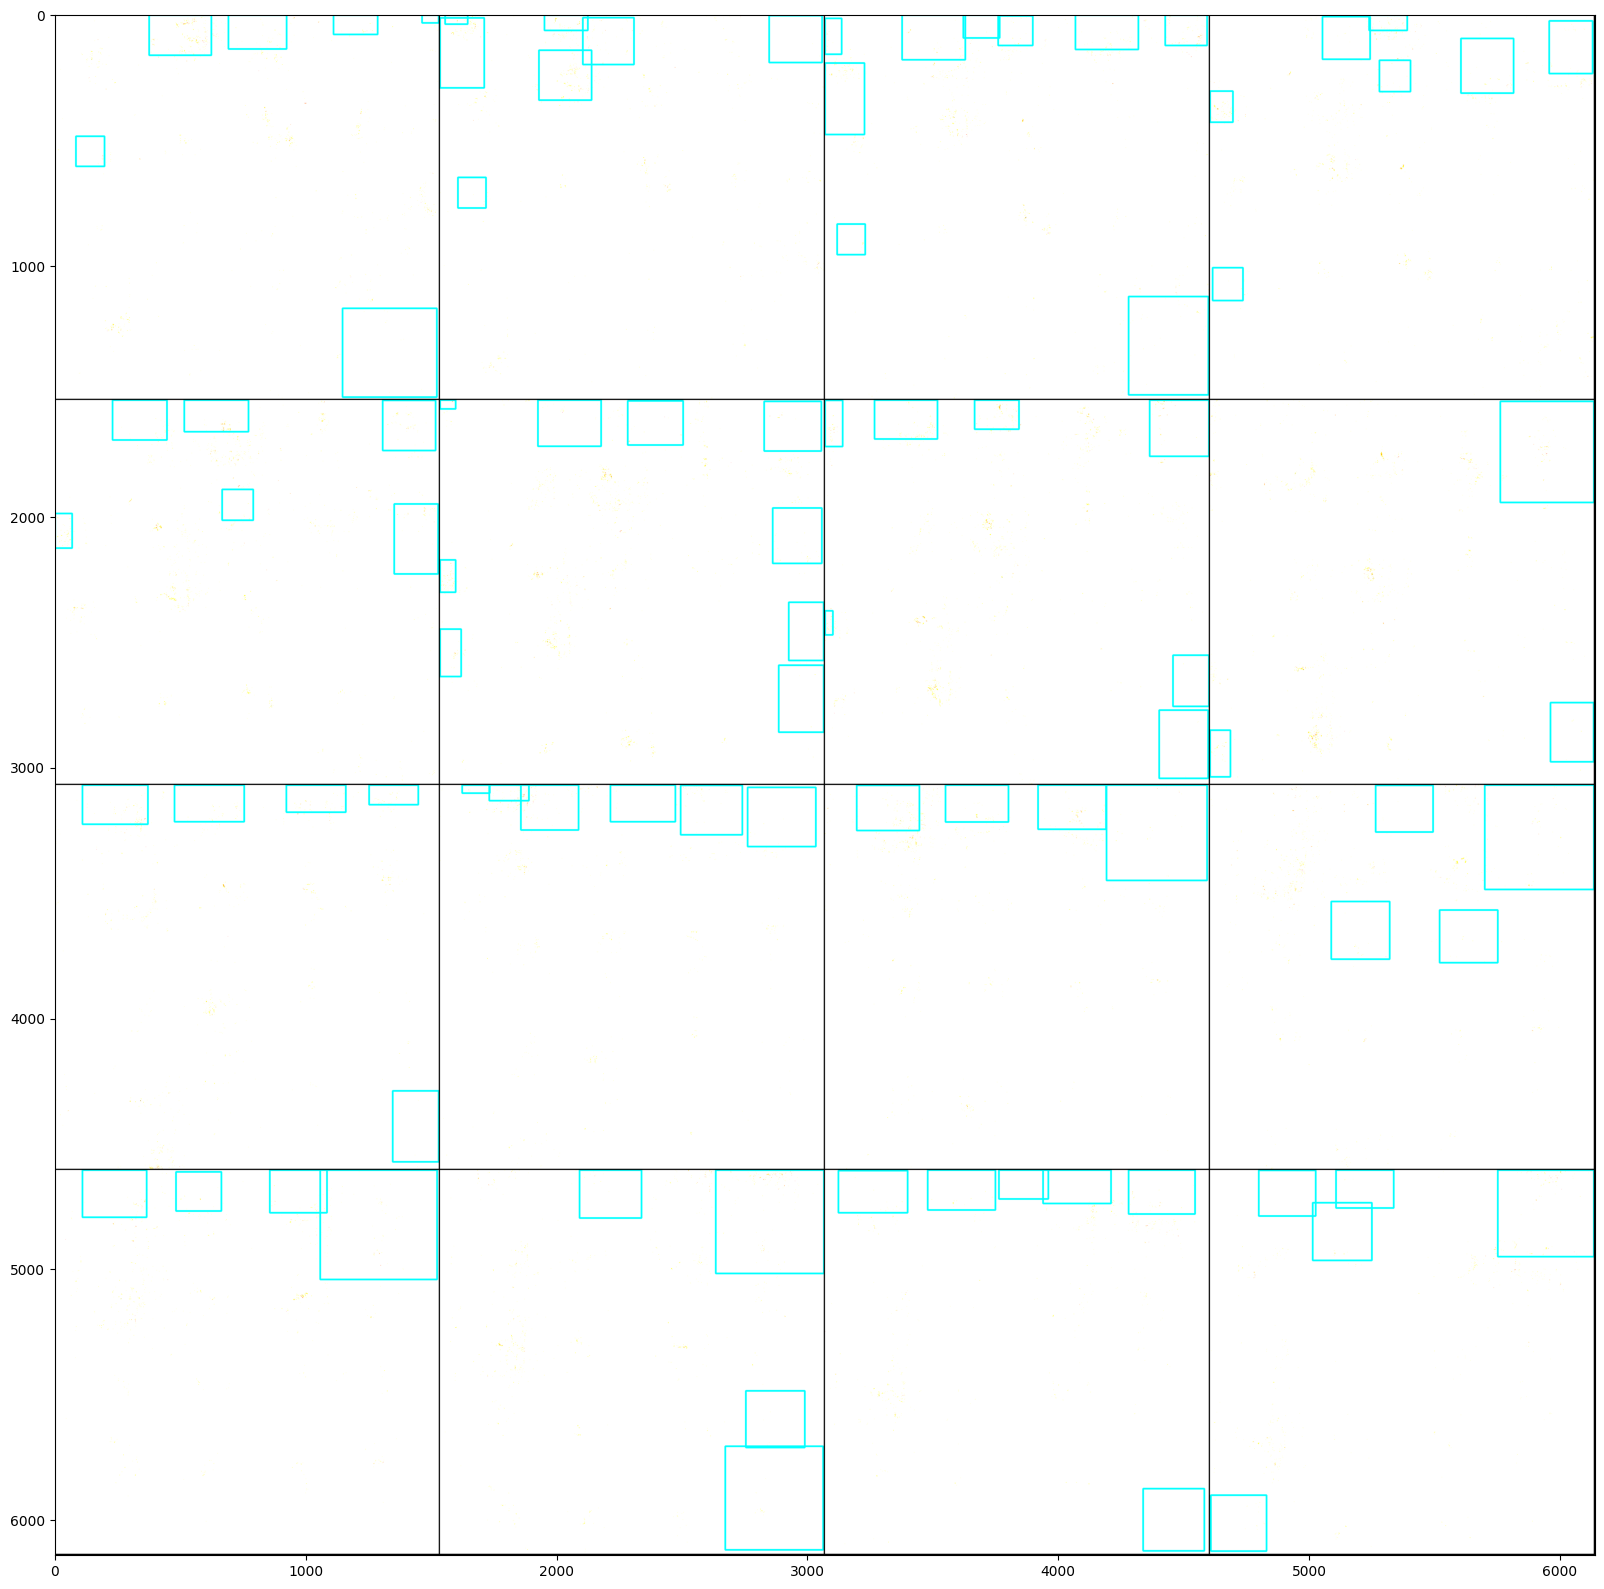

In [45]:
tile = 4
size=1530
margin=5
results = []
row=[]

ai = AI()
for k in range(190,206):
    generateGeoCodeImage(videoFileName,k,metaData.latitude[k],metaData.longitude[k])
    img = ai.predictAsImg(videoFileName,k)
    i = ((k-190) // tile)
    j = (k-190) % tile
    row.append(img[:,:,::-1])
    row.append(np.zeros((size,margin,3),dtype=int))
    if j == (tile - 1):
        rows = np.concatenate(row, axis=1 )
        results.append(rows)
        results.append(np.zeros((margin,(size+margin)*tile,3),dtype=int))
        row=[]
results = np.concatenate(results, axis=0 )
    

plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.show()
